In [1]:
import os
import numpy as np
import pandas as pd
import warnings
import joblib
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from scipy.stats import loguniform, randint


In [2]:
# Load the dataset
heartImputedDataset = pd.read_csv("heart_imputed.csv") 
print("Shape (rows, cols):", heartImputedDataset.shape)

Shape (rows, cols): (918, 12)


In [3]:
targetColumn = "HeartDisease"

# Features / target
XFeatures = heartImputedDataset.drop(columns=[targetColumn])
yTarget   = heartImputedDataset[targetColumn]

# Identify categorical & numeric columns
categoricalFeatureNames = XFeatures.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Treat numeric 0/1 columns as categorical
binaryNumericFeatureNames = [
    name for name in XFeatures.select_dtypes(include=["number"]).columns
    if set(pd.unique(XFeatures[name].dropna())) <= {0, 1}
]

categoricalFeatureNames = sorted(list(set(categoricalFeatureNames + binaryNumericFeatureNames)))
numericFeatureNames = [name for name in XFeatures.columns if name not in categoricalFeatureNames]

print("Categorical feature names:", categoricalFeatureNames)
print("Numeric feature names    :", numericFeatureNames)

# Train/test split (80/20), stratified
XTrain, XTest, yTrain, yTest = train_test_split(
    XFeatures, yTarget, test_size=0.20, random_state=42, stratify=yTarget
)
print("Train:", XTrain.shape, " Test:", XTest.shape)

Categorical feature names: ['ChestPainType', 'ExerciseAngina', 'FastingBS', 'RestingECG', 'ST_Slope', 'Sex']
Numeric feature names    : ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Train: (734, 11)  Test: (184, 11)


In [4]:
# Target distribution table
fullCounts  = heartImputedDataset["HeartDisease"].value_counts().reindex([0, 1]).fillna(0).astype(int)
trainCounts = yTrain.value_counts().reindex([0, 1]).fillna(0).astype(int)
testCounts  = yTest.value_counts().reindex([0, 1]).fillna(0).astype(int)

countsTable = pd.DataFrame({
    "Full":  fullCounts,
    "Train": trainCounts,
    "Test":  testCounts
})
countsTable.index.name = "HeartDisease"

print("\nTarget distribution — Full vs Train vs Test")
print(tabulate(countsTable.reset_index().values.tolist(),
               headers=["HeartDisease", "Full", "Train", "Test"],
               tablefmt="simple_outline"))



Target distribution — Full vs Train vs Test
┌────────────────┬────────┬─────────┬────────┐
│   HeartDisease │   Full │   Train │   Test │
├────────────────┼────────┼─────────┼────────┤
│              0 │    410 │     328 │     82 │
│              1 │    508 │     406 │    102 │
└────────────────┴────────┴─────────┴────────┘


In [5]:
# Preprocess: One-Hot Encode categoricals + Scale numericals

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categoricalFeatureNames),
        ("num", StandardScaler(), numericFeatureNames),
    ],
    remainder="drop"
)

# Fit on train, then transform train & test
XTrainProc = preprocessor.fit_transform(XTrain)
XTestProc  = preprocessor.transform(XTest)

# Feature names and DataFrame wrappers
featureNames = preprocessor.get_feature_names_out().tolist()
XTrainProc = pd.DataFrame(XTrainProc, columns=featureNames, index=XTrain.index)
XTestProc  = pd.DataFrame(XTestProc,  columns=featureNames, index=XTest.index)

print("Processed shapes →",
      "XTrainProc:", XTrainProc.shape,
      "| XTestProc:", XTestProc.shape)


Processed shapes → XTrainProc: (734, 15) | XTestProc: (184, 15)


In [6]:
# Train baseline models
modelLR  = LogisticRegression(max_iter=1000, solver="liblinear", C=1)
modelKNN = KNeighborsClassifier(n_neighbors=5, weights="distance")
modelRF  = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

# Fit on preprocessed training data
modelLR.fit(XTrainProc, yTrain)
modelKNN.fit(XTrainProc, yTrain)
modelRF.fit(XTrainProc, yTrain)

print("Models trained: LogisticRegression (LR), KNN, RandomForest (RF)")

Models trained: LogisticRegression (LR), KNN, RandomForest (RF)


In [7]:
def predictLabelsSafely(classifier, features):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return classifier.predict(features)

def predictClass1ProbabilitiesSafely(classifier, features):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if hasattr(classifier, "predict_proba"):
            probabilities = classifier.predict_proba(features)[:, 1]
        else:
            decisionScores = classifier.decision_function(features)
            probabilities = (decisionScores - decisionScores.min()) / (decisionScores.max() - decisionScores.min() + 1e-9)

    probabilities = np.nan_to_num(probabilities, nan=0.5, posinf=1.0, neginf=0.0)
    probabilities = np.clip(probabilities, 1e-8, 1 - 1e-8)
    return probabilities

def warningsSuppressed(searchCv, X, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return searchCv.fit(X, y)


In [8]:
# Evaluate models on the test set
def evaluateModel(classifier, XTestProcessed, yTestTrue, modelName):
    yPredicted = predictLabelsSafely(classifier, XTestProcessed)
    yProbability = predictClass1ProbabilitiesSafely(classifier, XTestProcessed)

    return {
        "Model": modelName,
        "Accuracy": round(accuracy_score(yTestTrue, yPredicted), 3),
        "Precision": round(precision_score(yTestTrue, yPredicted), 3),
        "Recall": round(recall_score(yTestTrue, yPredicted), 3),
        "F1": round(f1_score(yTestTrue, yPredicted), 3),
        "ROC-AUC": round(roc_auc_score(yTestTrue, yProbability), 3),
    }

evaluationRows = []
for classifier, modelName in [(modelLR, "LogReg"), (modelKNN, "KNN"), (modelRF, "RF")]:
    evaluationRows.append(evaluateModel(classifier, XTestProc, yTest, modelName))

metricsTable = pd.DataFrame(evaluationRows)
print(tabulate(metricsTable.values.tolist(),
               headers=metricsTable.columns.tolist(),
               tablefmt="simple_outline"))


┌─────────┬────────────┬─────────────┬──────────┬───────┬───────────┐
│ Model   │   Accuracy │   Precision │   Recall │    F1 │   ROC-AUC │
├─────────┼────────────┼─────────────┼──────────┼───────┼───────────┤
│ LogReg  │      0.891 │       0.887 │    0.922 │ 0.904 │     0.931 │
│ KNN     │      0.853 │       0.879 │    0.853 │ 0.866 │     0.93  │
│ RF      │      0.859 │       0.88  │    0.863 │ 0.871 │     0.929 │
└─────────┴────────────┴─────────────┴──────────┴───────┴───────────┘



Confusion Matrix — LogReg
┌────────┬──────────┬──────────┐
│        │   Pred 0 │   Pred 1 │
├────────┼──────────┼──────────┤
│ True 0 │       70 │       12 │
│ True 1 │        8 │       94 │
└────────┴──────────┴──────────┘

Confusion Matrix — KNN
┌────────┬──────────┬──────────┐
│        │   Pred 0 │   Pred 1 │
├────────┼──────────┼──────────┤
│ True 0 │       70 │       12 │
│ True 1 │       15 │       87 │
└────────┴──────────┴──────────┘

Confusion Matrix — RF
┌────────┬──────────┬──────────┐
│        │   Pred 0 │   Pred 1 │
├────────┼──────────┼──────────┤
│ True 0 │       70 │       12 │
│ True 1 │       14 │       88 │
└────────┴──────────┴──────────┘


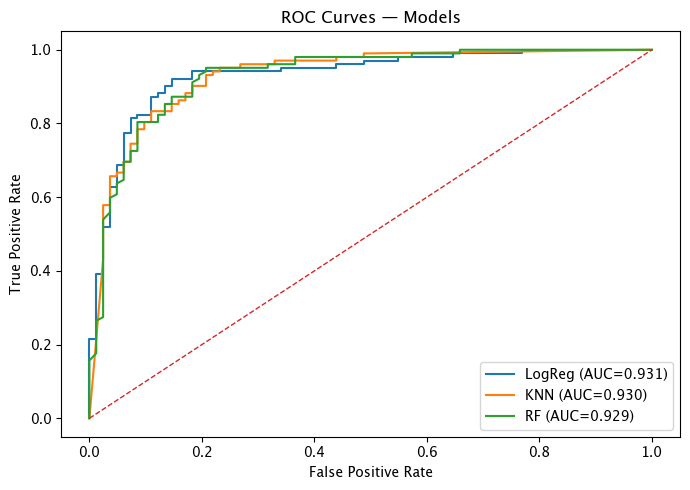

In [9]:
#  Confusion matrices and AUC  ROC curves

for classifier, modelName in [(modelLR, "LogReg"), (modelKNN, "KNN"), (modelRF, "RF")]:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yPredicted = classifier.predict(XTestProc)
    confusion = confusion_matrix(yTest, yPredicted)
    confusionTable = [
        ["True 0", confusion[0, 0], confusion[0, 1]],
        ["True 1", confusion[1, 0], confusion[1, 1]],
    ]
    print(f"\nConfusion Matrix — {modelName}")
    print(tabulate(confusionTable, headers=["", "Pred 0", "Pred 1"], tablefmt="simple_outline"))

# ROC curves 
plt.figure(figsize=(7, 5))
for classifier, modelName in [(modelLR, "LogReg"), (modelKNN, "KNN"), (modelRF, "RF")]:
    yProbabilities = predictClass1ProbabilitiesSafely(classifier, XTestProc)
    falsePositiveRate, truePositiveRate, _ = roc_curve(yTest, yProbabilities)
    aucValue = roc_auc_score(yTest, yProbabilities)
    plt.plot(falsePositiveRate, truePositiveRate, label=f"{modelName} (AUC={aucValue:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("ROC Curves — Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Hyperparameter tuning using RandomizedSearchCV
crossValidator = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoringMetric = "roc_auc"

# Logistic Regression search space
logRegSearch = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=2000, solver="liblinear"),
    param_distributions={"C": loguniform(1e-3, 1e2), "penalty": ["l1", "l2"]},
    n_iter=40, cv=crossValidator, scoring=scoringMetric,
    n_jobs=-1, random_state=42, refit=True, verbose=0
)
warningsSuppressed(logRegSearch, XTrainProc, yTrain)

# KNN search space
knnSearch = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions={"n_neighbors": randint(3, 51), "weights": ["uniform", "distance"], "p": [1, 2]},
    n_iter=50, cv=crossValidator, scoring=scoringMetric,
    n_jobs=-1, random_state=42, refit=True, verbose=0
)
warningsSuppressed(knnSearch, XTrainProc, yTrain)

# Random Forest search space
randomForestSearch = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions={
        "n_estimators": randint(200, 800),
        "max_depth": [None] + list(range(4, 21)),
        "min_samples_split": randint(2, 10),
        "min_samples_leaf": randint(1, 8),
        "max_features": ["sqrt", "log2", 0.5, 0.7],
    },
    n_iter=60, cv=crossValidator, scoring=scoringMetric,
    n_jobs=-1, random_state=42, refit=True, verbose=0
)
warningsSuppressed(randomForestSearch, XTrainProc, yTrain)

# Show best CV AUC and params
bestRows = [
    ["LogReg", round(logRegSearch.best_score_, 3), logRegSearch.best_params_],
    ["KNN",    round(knnSearch.best_score_, 3),    knnSearch.best_params_],
    ["RF",     round(randomForestSearch.best_score_, 3), randomForestSearch.best_params_],
]
print("\nBest CV AUCs & Params (RandomizedSearchCV)")
print(tabulate(bestRows, headers=["Model", "Best CV AUC", "Best Params"], tablefmt="simple_outline"))



Best CV AUCs & Params (RandomizedSearchCV)
┌─────────┬───────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Model   │   Best CV AUC │ Best Params                                                                                                   │
├─────────┼───────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ LogReg  │         0.923 │ {'C': np.float64(0.9846738873614566), 'penalty': 'l1'}                                                        │
│ KNN     │         0.922 │ {'n_neighbors': 36, 'p': 1, 'weights': 'distance'}                                                            │
│ RF      │         0.929 │ {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 655} │
└─────────┴───────────────┴─────────────────────────────────────────────────────────────────────────────────────────

In [11]:
# Evaluate tuned models on the test set
tunedResults = []
tunedResults.append(evaluateModel(logRegSearch.best_estimator_,  XTestProc, yTest, "LogReg (tuned)"))
tunedResults.append(evaluateModel(knnSearch.best_estimator_,     XTestProc, yTest, "KNN (tuned)"))
tunedResults.append(evaluateModel(randomForestSearch.best_estimator_, XTestProc, yTest, "RF (tuned)"))

tunedMetricsTable = pd.DataFrame(tunedResults)
print("\nTuned Models — Test Metrics")
print(tabulate(tunedMetricsTable.values.tolist(),
               headers=tunedMetricsTable.columns.tolist(),
               tablefmt="simple_outline"))


Tuned Models — Test Metrics
┌────────────────┬────────────┬─────────────┬──────────┬───────┬───────────┐
│ Model          │   Accuracy │   Precision │   Recall │    F1 │   ROC-AUC │
├────────────────┼────────────┼─────────────┼──────────┼───────┼───────────┤
│ LogReg (tuned) │      0.902 │       0.904 │    0.922 │ 0.913 │     0.933 │
│ KNN (tuned)    │      0.864 │       0.889 │    0.863 │ 0.876 │     0.932 │
│ RF (tuned)     │      0.853 │       0.864 │    0.873 │ 0.868 │     0.921 │
└────────────────┴────────────┴─────────────┴──────────┴───────┴───────────┘



Confusion Matrix — LogReg (tuned)
┌────────┬──────────┬──────────┐
│        │   Pred 0 │   Pred 1 │
├────────┼──────────┼──────────┤
│ True 0 │       72 │       10 │
│ True 1 │        8 │       94 │
└────────┴──────────┴──────────┘

Confusion Matrix — KNN (tuned)
┌────────┬──────────┬──────────┐
│        │   Pred 0 │   Pred 1 │
├────────┼──────────┼──────────┤
│ True 0 │       71 │       11 │
│ True 1 │       14 │       88 │
└────────┴──────────┴──────────┘

Confusion Matrix — RF (tuned)
┌────────┬──────────┬──────────┐
│        │   Pred 0 │   Pred 1 │
├────────┼──────────┼──────────┤
│ True 0 │       68 │       14 │
│ True 1 │       13 │       89 │
└────────┴──────────┴──────────┘


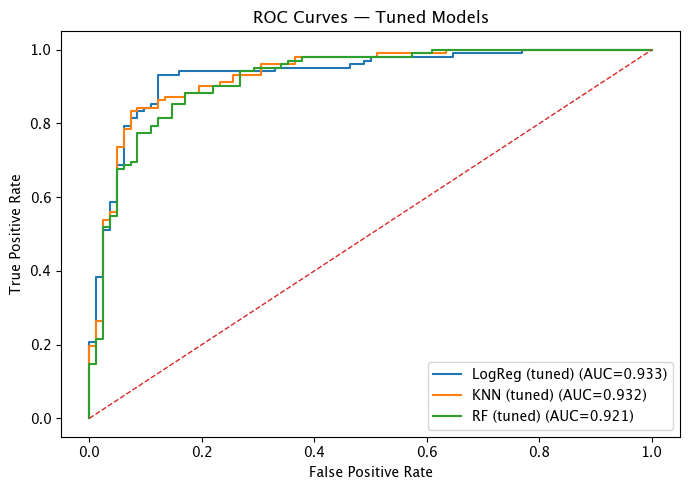

In [12]:
tunedModels = [
    (logRegSearch.best_estimator_,        "LogReg (tuned)"),
    (knnSearch.best_estimator_,           "KNN (tuned)"),
    (randomForestSearch.best_estimator_,  "RF (tuned)"),
]

# Confusion matrices (pretty table)
for classifier, modelName in tunedModels:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yPredicted = classifier.predict(XTestProc)
    confusion = confusion_matrix(yTest, yPredicted)
    confusionTable = [
        ["True 0", confusion[0, 0], confusion[0, 1]],
        ["True 1", confusion[1, 0], confusion[1, 1]],
    ]
    print(f"\nConfusion Matrix — {modelName}")
    print(tabulate(confusionTable, headers=["", "Pred 0", "Pred 1"], tablefmt="simple_outline"))

# ROC curves (with AUC in legend) — reuse predictClass1ProbabilitiesSafely from Block 5
plt.figure(figsize=(7, 5))
for classifier, modelName in tunedModels:
    yProbabilities = predictClass1ProbabilitiesSafely(classifier, XTestProc)
    fpr, tpr, _ = roc_curve(yTest, yProbabilities)
    aucValue = roc_auc_score(yTest, yProbabilities)
    plt.plot(fpr, tpr, label=f"{modelName} (AUC={aucValue:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("ROC Curves — Tuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Save preprocessor, models, and metrics

artifactsDirectory = "artifacts"
os.makedirs(artifactsDirectory, exist_ok=True)

# Save fitted preprocessor
joblib.dump(preprocessor, os.path.join(artifactsDirectory, "preprocessor.joblib"))

# Save tuned models
joblib.dump(logRegSearch.best_estimator_, os.path.join(artifactsDirectory, "model_lr_tuned.joblib"))
joblib.dump(knnSearch.best_estimator_, os.path.join(artifactsDirectory, "model_knn_tuned.joblib"))
joblib.dump(randomForestSearch.best_estimator_, os.path.join(artifactsDirectory, "model_rf_tuned.joblib"))

print("Saved to:", os.path.abspath(artifactsDirectory))


Saved to: /Users/sivasai/Downloads/Projects/Navneeth/artifacts
